In [2]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [3]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post: 
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [4]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [5]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
    

In [6]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [7]:
tokenized_text.max().item()

100069

In [8]:
# Illustration purpose
print(encoding.encode('测试aaa中国你好'))



[82805, 33746, 59795, 57668, 53901]


In [9]:
print(encoding.decode([82805, 33746, 59795])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]

测试aaa中国


In [10]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [11]:
train_data

tensor([26072,   220,    16,  ...,  1501, 48451,  7119])

In [12]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [13]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [14]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [15]:
x_batch.data.numpy().shape

(4, 16)

In [16]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [17]:
P = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                     (-math.log(10000)/d_model))
P[:,0::2] = torch.sin(position.unsqueeze(1) * div_term)
P[:,1::2] = torch.cos(position.unsqueeze(1) * div_term)
position_encoding_lookup_table = P.unsqueeze(0).expand(batch_size, -1, -1)



In [18]:
P.shape

torch.Size([16, 64])

In [19]:
position.unsqueeze(1).shape

torch.Size([16, 1])

In [20]:
a=position.unsqueeze(1) * div_term
a.shape

torch.Size([16, 32])

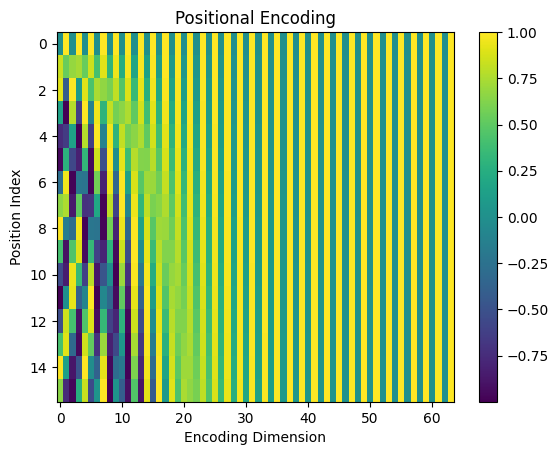

In [22]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [26]:
input_embedding_x = x_batch_embedding + position_encoding_lookup_table
input_embedding_y = y_batch_embedding + position_encoding_lookup_table

In [34]:
X = input_embedding_x
query = key = value = X
query.shape

torch.Size([4, 16, 64])

In [36]:
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query)
Q = Q.view(batch_size, context_length, num_heads, d_model//num_heads)


K = Wk(key)
K = K.view(batch_size, context_length, num_heads, d_model//num_heads)


V= Wv(value)
V = V.view(batch_size, context_length, num_heads, d_model//num_heads)



In [37]:
Q.shape

torch.Size([4, 16, 4, 16])

In [41]:
Q = Q.transpose(1,2) # head和length转置
K = K.transpose(1,2) # head和length转置
V = V.transpose(1,2) # head和length转置

In [42]:
Q.shape

torch.Size([4, 4, 16, 16])

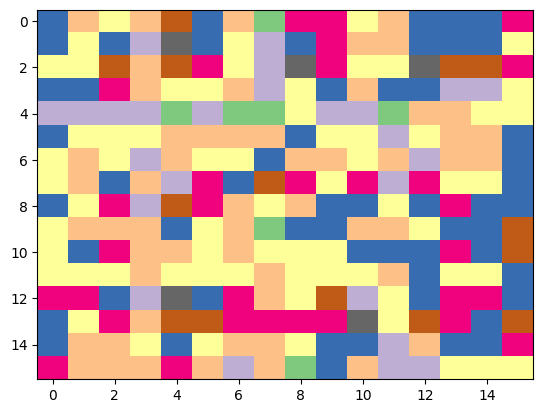

In [46]:

attenstion_score = torch.matmul(Q, K.transpose(2,3)/math.sqrt(d_model//num_heads))

attenstion_score[0,0].detach().cpu().numpy()
# Illustration only
plt.imshow(attenstion_score[0, 0].detach().cpu().numpy(), "Accent", aspect="auto")


In [100]:
tr = torch.triu(torch.ones(attenstion_score.shape[-2:]),diagonal=1).bool()
attention_score = attenstion_score.masked_fill(tr, float('-inf'))


In [101]:
attention_score.shape

torch.Size([4, 4, 16, 16])

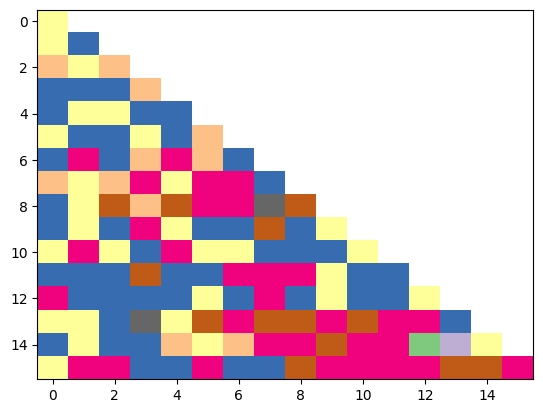

In [102]:

# Illustration only
# -inf 是因为要取e，然后才是0
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")


In [103]:
attention_score = torch.softmax(attenstion_score, dim=-1)
A = torch.matmul(attention_score, V) 

In [104]:
pd.DataFrame(attention_score[0,0].detach().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.632661,0.367339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.248945,0.227388,0.523668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.234353,0.281509,0.321676,0.162463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.234260,0.197167,0.201268,0.228996,0.138309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.216887,0.179086,0.181667,0.163415,0.139926,0.119019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.155953,0.125688,0.166474,0.103770,0.114820,0.179286,0.154009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.102176,0.079344,0.143639,0.072864,0.047244,0.164770,0.128865,0.261099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.119759,0.093414,0.164766,0.041559,0.226289,0.137991,0.063848,0.088932,0.063442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.114367,0.078637,0.089275,0.079248,0.166835,0.097999,0.071462,0.037701,0.131573,0.132903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [105]:
attention_score[0,0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6327, 0.3673, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2489, 0.2274, 0.5237, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2344, 0.2815, 0.3217, 0.1625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2343, 0.1972, 0.2013, 0.2290, 0.1383, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2169, 0.1791, 0.1817, 0.1634, 0.1399, 0.1190, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1560, 0.1257, 0.1665, 0.1038, 0.1148, 0.1793, 0.1540, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

In [106]:
A.shape

torch.Size([4, 4, 16, 16])

In [107]:
A = A.transpose(1,2).contiguous()
A = A.view(batch_size, -1, d_model)

A.shape

In [108]:
A.shape

torch.Size([4, 16, 64])

In [109]:
Wo = nn.Linear(d_model, d_model)
output = Wo(A)


In [110]:
output = output + X

In [111]:
output

tensor([[[ 1.4990, -0.3425,  0.4635,  ...,  0.9253,  1.3182,  0.4416],
         [ 1.3439, -0.7461,  2.3522,  ...,  1.1699,  0.8085,  1.2067],
         [ 0.4248,  1.1523,  0.4801,  ...,  1.3907, -0.7241,  0.0148],
         ...,
         [ 0.8261, -0.3271, -2.7982,  ...,  2.8960, -0.3673, -0.5443],
         [-0.2824,  1.0817, -0.6932,  ...,  1.4786,  0.3442,  0.6805],
         [ 1.0254, -1.2167, -2.2732,  ...,  0.5911,  0.4745,  1.1276]],

        [[-0.8084,  0.1477,  0.3044,  ...,  0.1438, -0.8533,  1.8466],
         [ 2.3581,  0.6657, -0.9369,  ...,  1.2377, -2.8281,  1.2365],
         [ 1.1613, -0.6605,  1.5331,  ...,  0.7474, -0.5178,  0.7363],
         ...,
         [ 0.9468,  2.2336, -0.9223,  ..., -0.2380,  1.3014,  1.3700],
         [ 1.9926, -0.8190, -0.2059,  ...,  2.4073, -1.0366, -1.0036],
         [ 1.7545, -0.4689, -0.8416,  ...,  2.4416,  1.6980, -0.3756]],

        [[ 0.0582, -1.5160, -0.7490,  ..., -0.4399, -1.8250,  0.4969],
         [-0.6959,  1.5554,  0.3497,  ..., -0

In [112]:
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [113]:
outout  = nn.Linear(d_model, d_model*4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model*4, d_model)(output)
output = output + output_layernorm
output = layer_norm(output)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 256x64)

In [114]:
output

tensor([[[1.4990, 0.0000, 0.4635,  ..., 0.9253, 1.3182, 0.4416],
         [1.3439, 0.0000, 2.3522,  ..., 1.1699, 0.8085, 1.2067],
         [0.4248, 1.1523, 0.4801,  ..., 1.3907, 0.0000, 0.0148],
         ...,
         [0.8261, 0.0000, 0.0000,  ..., 2.8960, 0.0000, 0.0000],
         [0.0000, 1.0817, 0.0000,  ..., 1.4786, 0.3442, 0.6805],
         [1.0254, 0.0000, 0.0000,  ..., 0.5911, 0.4745, 1.1276]],

        [[0.0000, 0.1477, 0.3044,  ..., 0.1438, 0.0000, 1.8466],
         [2.3581, 0.6657, 0.0000,  ..., 1.2377, 0.0000, 1.2365],
         [1.1613, 0.0000, 1.5331,  ..., 0.7474, 0.0000, 0.7363],
         ...,
         [0.9468, 2.2336, 0.0000,  ..., 0.0000, 1.3014, 1.3700],
         [1.9926, 0.0000, 0.0000,  ..., 2.4073, 0.0000, 0.0000],
         [1.7545, 0.0000, 0.0000,  ..., 2.4416, 1.6980, 0.0000]],

        [[0.0582, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4969],
         [0.0000, 1.5554, 0.3497,  ..., 0.0000, 0.6761, 1.2784],
         [1.0386, 0.0000, 1.3345,  ..., 0.9095, 0.0000, 0.

In [115]:
logits  = nn.Linear(d_model, max_token_value+1)(output)
logits.shape

torch.Size([4, 16, 100070])

In [116]:
prob = torch.softmax(logits, dim=-1)
pd.DataFrame(prob[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000005,0.000009,0.000013,0.000005,0.000007,0.000003,0.000004,0.000005,0.000006,0.000006,...,0.000005,0.000003,0.000005,0.000005,0.000003,0.000007,0.000006,0.000022,0.000006,0.000006
1,0.000007,0.000007,0.000030,0.000006,0.000006,0.000007,0.000003,0.000010,0.000004,0.000005,...,0.000018,0.000004,0.000004,0.000012,0.000003,0.000007,0.000008,0.000022,0.000006,0.000005
2,0.000005,0.000008,0.000026,0.000004,0.000006,0.000003,0.000008,0.000003,0.000005,0.000010,...,0.000024,0.000004,0.000009,0.000006,0.000003,0.000005,0.000009,0.000023,0.000009,0.000002
3,0.000006,0.000007,0.000012,0.000011,0.000008,0.000009,0.000004,0.000003,0.000006,0.000008,...,0.000013,0.000005,0.000006,0.000005,0.000013,0.000007,0.000005,0.000015,0.000013,0.000005
4,0.000004,0.000005,0.000017,0.000006,0.000012,0.000008,0.000010,0.000003,0.000003,0.000008,...,0.000018,0.000002,0.000024,0.000006,0.000004,0.000012,0.000005,0.000026,0.000011,0.000002
5,0.000010,0.000008,0.000019,0.000005,0.000005,0.000009,0.000007,0.000003,0.000005,0.000006,...,0.000018,0.000005,0.000016,0.000005,0.000005,0.000009,0.000006,0.000039,0.000012,0.000005
6,0.000005,0.000014,0.000011,0.000003,0.000011,0.000008,0.000009,0.000002,0.000003,0.000008,...,0.000014,0.000003,0.000010,0.000007,0.000005,0.000005,0.000008,0.000032,0.000007,0.000002
7,0.000003,0.000013,0.000016,0.000004,0.000010,0.000010,0.000003,0.000002,0.000002,0.000007,...,0.000022,0.000005,0.000028,0.000010,0.000006,0.000007,0.000007,0.000031,0.000010,0.000002
8,0.000003,0.000011,0.000010,0.000011,0.000003,0.000004,0.000002,0.000004,0.000004,0.000006,...,0.000009,0.000002,0.000019,0.000006,0.000005,0.000009,0.000012,0.000009,0.000007,0.000002
9,0.000006,0.000007,0.000009,0.000005,0.000007,0.000004,0.000005,0.000005,0.000007,0.000009,...,0.000005,0.000003,0.000006,0.000005,0.000004,0.000007,0.000006,0.000019,0.000006,0.000004


In [119]:
predicted_index = torch.argmax(logits[0,15]).item()
encoding.decode([predicted_index])

' epidemic'

In [118]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'